# ***词向量运算***

# 0. 要解决的问题

① 因为训练单词嵌入在计算上非常耗时耗力，所以大多数ML练习者都会加载一组经过预先训练的嵌入。

② 完成此任务后，你将能够：

 - 加载预训练的词向量，并使用余弦相似度测量相似度。
 - 使用单词嵌入来解决单词类比问题，例如“男人相对女人”，“国王相对__”。
 - 修改词嵌入以减少其性别偏见。

# 1. 导入库

In [1]:
import numpy as np
import w2v_utils

Using TensorFlow backend.
D:\11_Anaconda\envs\py3.6.3\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


# 2. 加载词向量

① 我们加载单词向量。

② 对于此作业，我们将使用50维GloVe向量表示单词。

③ 运行以下单元格以加载word_to_vec_map。

In [2]:
words, word_to_vec_map = w2v_utils.read_glove_vecs('datasets/glove.6B.50d.txt')

In [3]:
# python 3.x
print(word_to_vec_map['hello'])

# python 2.x
# print word_to_vec_map['hello']

[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


④ 你已加载：

 - words：词汇表中的单词集。
 - word_to_vec_map：将单词映射到其GloVe向量表示的字典上。

⑤ 你已经看到，单向向量不能很好地说明相似的单词。

⑥ GloVe向量提供有关单个单词含义的更多有用信息。

⑦ 现在让我们看看如何使用GloVe向量确定两个单词的相似程度。

# 3. 余弦相似度

① 要测量两个单词的相似程度，我们需要一种方法来测量两个单词的两个嵌入向量之间的相似度。

② 给定两个向量$u$和$v$，余弦相似度定义如下：$$\text{CosineSimilarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

③ 其中$u.v$是两个向量的点积（或内积），$||u||_2$是向量$u$的范数（或长度），而$\theta$是$u$和$v$之间的夹角。

④ 这种相似性取决于$u$和$v$之间的角度。如果$u$和$v$非常相似，它们的余弦相似度将接近1；如果它们不相似，则余弦相似度将取较小的值。

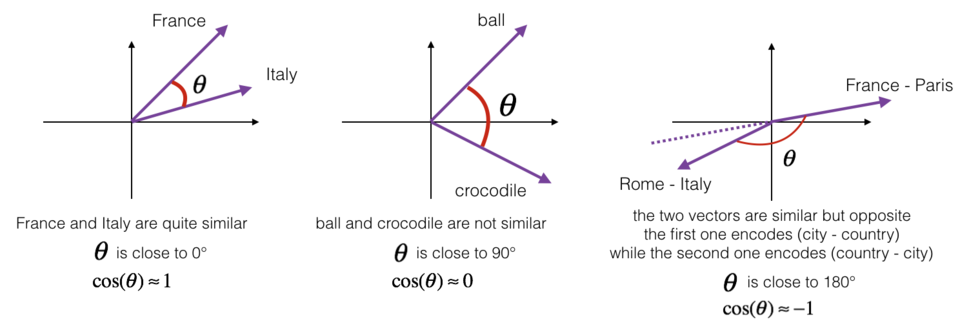

<center>图1：两个向量之间的夹角余弦表示它们的相似度</center>

⑤ 练习：实现函数cosine_similarity()以评估单词向量之间的相似性。
 - 提醒：$u$的范数定义为$||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

In [4]:
def cosine_similarity(u, v):
    """
    u与v的余弦相似度反映了u与v的相似程度
    
    参数：
        u -- 维度为(n,)的词向量
        v -- 维度为(n,)的词向量
        
    返回：
        cosine_similarity -- 由上面公式定义的u和v之间的余弦相似度。
    """
    distance = 0
    
    # 计算u与v的内积
    dot = np.dot(u, v)
    
    #计算u的L2范数
    norm_u = np.sqrt(np.sum(np.power(u, 2)))
    
    #计算v的L2范数
    norm_v = np.sqrt(np.sum(np.power(v, 2)))
    
    # 根据公式1计算余弦相似度
    cosine_similarity = np.divide(dot, norm_u * norm_v)
    
    return cosine_similarity

In [5]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))

cosine_similarity(father, mother) =  0.8909038442893615
cosine_similarity(ball, crocodile) =  0.27439246261379424
cosine_similarity(france - paris, rome - italy) =  -0.6751479308174201


① 获得正确的预期输出后，请随时修改输入并测量其他词对之间的余弦相似度！

② 围绕其他输入的余弦相似性进行操作将使你对单词向量的表征有更好的了解。

# 4. 单词类比任务

① 在类比任务中，我们完成句子"a is to b as c is to __"。 
 - 一个例子是'man is to woman as king is to queen'。 

② 详细地说，我们试图找到一个单词d，以使关联的单词向量$e_a, e_b, e_c, e_d$通过以下方式相关：$$e_b - e_a \approx e_d - e_c$$

③ 我们将使用余弦相似性来衡量$e_b - e_a$和$e_d - e_c$之间的相似性。

④ 练习：完成以下代码即可执行单词类比！

In [6]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    解决“A与B相比就类似于C与____相比一样”之类的问题
    
    参数：
        word_a -- 一个字符串类型的词
        word_b -- 一个字符串类型的词
        word_c -- 一个字符串类型的词
        word_to_vec_map -- 字典类型，单词到GloVe向量的映射
        
    返回：
        best_word -- 满足(v_b - v_a) 最接近 (v_best_word - v_c) 的词
    """
    
    # 把单词转换为小写
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    # 获取对应单词的词向量
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    
    # 获取全部的单词
    words = word_to_vec_map.keys()
    
    # 将max_cosine_sim初始化为一个比较大的负数
    max_cosine_sim = -100
    best_word = None
    
    # 遍历整个数据集
    for word in words:
        # 要避免匹配到输入的数据
        if word in [word_a, word_b, word_c]:
            continue
        # 计算余弦相似度
        cosine_sim = cosine_similarity((e_b - e_a), (word_to_vec_map[word] - e_c))
        
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = word
            
    return best_word

In [7]:
triads_to_try = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for triad in triads_to_try:
    print ('{} -> {} <====> {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

italy -> italian <====> spain -> spanish
india -> delhi <====> japan -> tokyo
man -> woman <====> boy -> girl
small -> smaller <====> large -> larger


① 一旦获得正确的预期输出，请随时修改上面的输入单元以测试你自己的类比。

② 尝试找到其他可行的类比对，但还要找到一些算法无法给出正确答案的类比对。

 - 例如，你可以尝试使用small-> smaller正如big->?。

③ 恭喜！你到了本作业的结尾。以下是你应记住的要点：

 - 余弦相似度是比较单词向量对之间相似度的好方法。（尽管L2距离也适用。）
 - 对于NLP应用程序，使用互联网上经过预先训练的一组词向量通常是入门的好方法。

In [8]:
triads_to_try = [('small', 'smaller', 'big')]
for triad in triads_to_try:
    print ('{} -> {} <====> {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

small -> smaller <====> big -> competitors


# 5. 去偏见词向量

① 在下面的练习中，你将研究可嵌入词嵌入的性别偏见，并探索减少偏见的算法。

② 除了了解去偏斜的主题外，本练习还将帮助你磨清直觉，了解单词向量在做什么。

③ 本节涉及一些线性代数，尽管即使你不擅长线性代数，你也可以完成它，我们鼓励你尝试一下。笔记本的此部分是可选的，未分级。

① 首先让我们看看GloVe词嵌入与性别之间的关系。

② 你将首先计算向量$g = e_{woman}-e_{man}$，其中$e_ {woman}$表示与单词woman对应的单词向量，而$e_{man}$则与单词对应与单词man对应的向量。

③ 所得向量$g$大致编码“性别”的概念。（如果你计算$g_1 = e_{mother}-e_{father}$,$g_2 = e_{girl}-e_{boy}$等，并对其进行平均，则可能会得到更准确的表示。但是仅使用$e_{woman}-e_{man}$会给你足够好的结果。）

In [9]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


① 现在，你将考虑一下不同单词$g$的余弦相似度。考虑相似性的正值与余弦相似性的负值意味着什么。

In [10]:
print ('List of names and their similarities with constructed vector:')

name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

List of names and their similarities with constructed vector:
john -0.23163356145973724
marie 0.31559793539607295
sophie 0.31868789859418784
ronaldo -0.3124479685032943
priya 0.17632041839009407
rahul -0.16915471039231722
danielle 0.24393299216283892
reza -0.0793042967219955
katy 0.2831068659572615
yasmin 0.23313857767928753


② 如你所见，女性名字与我们构造的向量$g$的余弦相似度为正，而男性名字与余弦的相似度为负。这并不令人惊讶，结果似乎可以接受。

③ 但是，让我们尝试其他一些话。

In [11]:
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

lipstick 0.2769191625638267
guns -0.1888485567898898
science -0.060829065409296994
arts 0.008189312385880351
literature 0.0647250443345993
warrior -0.20920164641125288
doctor 0.1189528941093504
tree -0.07089399175478091
receptionist 0.3307794175059374
technology -0.13193732447554293
fashion 0.03563894625772701
teacher 0.1792092343182567
engineer -0.08039280494524072
pilot 0.0010764498991917152
computer -0.10330358873850494
singer 0.1850051813649629


① 你有什么惊讶的地方吗？令人惊讶的是，这些结果如何反映出某些不健康的性别定型观念。

 - 例如，"computer"更接近 "man"，而"literature" 更接近"woman"。

② 我们将在下面看到如何使用Boliukbasi et al., 2016提出的算法来减少这些向量的偏差。

③ 注意，诸如 "actor"/"actress" 或者 "grandmother"/"grandfather"之类的词对应保持性别特定，而诸如"receptionist" 或者"technology"之类的其他词语应被中和，即与性别无关。

④ 消除偏见时，你将不得不区别对待这两种类型的单词。

## 5.1 消除非性别特定词的偏见

① 下图应帮助你直观地了解中和的作用。

② 如果你使用的是50维词嵌入，则50维空间可以分为两部分：偏移方向$g$和其余49维，我们将其称为$g_{\perp}$。

③ 在线性代数中，我们说49维$g_{\perp}$与$g$垂直（或“正交”），这意味着它与$g$成90度。

④ 中和步骤采用向量，例如$e_{receptionist}$，并沿$g$的方向将分量清零，从而得到$e_{receptionist}^{debiased}$。

⑤ 即使$g_{\perp}$是49维的，鉴于我们可以在屏幕上绘制的内容的局限性，我们还是使用下面的1维轴对其进行说明。

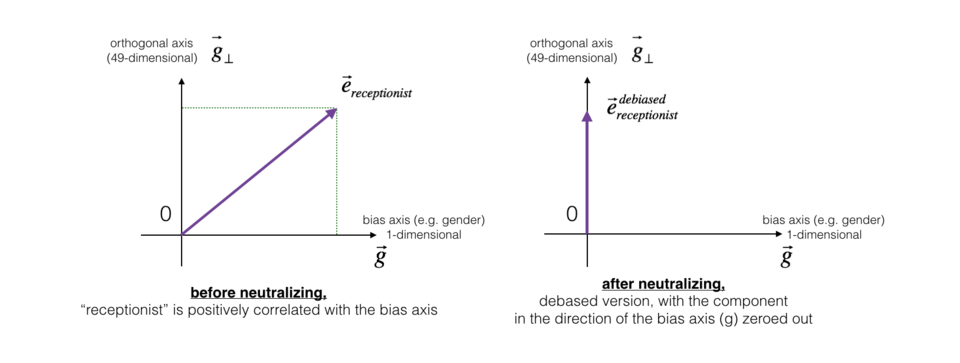

<center>图2 ：在应用中和操作之前和之后，代表"receptionist"的单词向量</center>

① 练习：实现neutralize()以消除诸如 "receptionist" 或 "scientist" 之类的词的偏见。

② 给定嵌入$e$的输入，你可以使用以下公式来计算$e^{debiased}$:

$$e^{bias\_component} = \frac{e*g}{||g||_2^2} * g\tag{2}$$

$$e^{debiased} = e - e^{bias\_component}\tag{3}$$

③ 如果你是线性代数方面的专家，则可以将$e^{bias\_component}$识别为$e$在$g$方向上的投影。

④ 如果你不是线性代数方面的专家，请不必为此担心。

⑤ 向量$u$可分为两部分：在向量轴$v_B$上的投影和在与$v$正交的轴上的投影：$u = u_B + u_{\perp}$
 - 其中：$u_{\perp} = u - u_B$

In [12]:
def neutralize(word, g, word_to_vec_map):
    """
    通过将“word”投影到与偏置轴正交的空间上，消除了“word”的偏差。
    该函数确保“word”在性别的子空间中的值为0
    
    参数：
        word -- 待消除偏差的字符串
        g -- 维度为(50,)，对应于偏置轴（如性别）
        word_to_vec_map -- 字典类型，单词到GloVe向量的映射
        
    返回：
        e_debiased -- 消除了偏差的向量。
    """
    
    # 根据word选择对应的词向量
    e = word_to_vec_map[word]
    
    # 根据公式2计算e_biascomponent
    e_biascomponent = np.divide(np.dot(e, g), np.square(np.linalg.norm(g))) * g
    
    # 根据公式3计算e_debiased
    e_debiased = e - e_biascomponent
    
    return e_debiased

In [13]:
e = "receptionist"
print("去偏差前{0}与g的余弦相似度为：{1}".format(e, cosine_similarity(word_to_vec_map["receptionist"], g)))

e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("去偏差后{0}与g的余弦相似度为：{1}".format(e, cosine_similarity(e_debiased, g)))

去偏差前receptionist与g的余弦相似度为：0.3307794175059374
去偏差后receptionist与g的余弦相似度为：-5.2569290990191626e-17


## 5.2 性别专用词的均衡算法

① 接下来，让我们看一下如何将偏置也应用于单词对，例如"actress"和"actor"。

② 均衡仅应用与你希望通过性别属性有所不同的单词对。作为具体示例，假设"actress"比"actor"更接近"babysit"。

③ 通过将中和应用于"babysit"，我们可以减少与"babysit"相关的性别刻板印象。

④ 但这仍然不能保证"actress"和"actor"与"babysit"等距，均衡算法负责这一点。

⑤ 均衡背后的关键思想是确保一对特定单词与49维$g_\perp$等距。

⑥ 均衡步骤还确保了两个均衡步骤现在与$e_{receptionist}^{debiased}$或与任何其他已中和的作品之间的距离相同。

⑦ 图片中展示了均衡的工作方式：

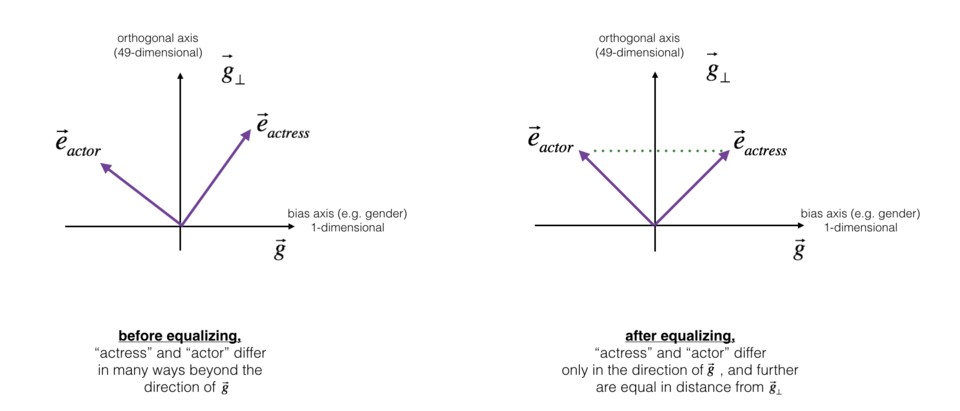

① 为此，线性代数的推导要复杂一些。（详细信息请参见Bolukbasi et al., 2016）但其关键方程式是：

$$\mu = \frac{e_{w1} + e_{w2}}{2}\tag{4}$$

$$\mu_{B} = \frac {\mu *  \text{bias_axis}}{||\text{bias_axis}||_2} + ||\text{bias_axis}||_2 *\text{bias_axis}$$

$$\mu_{\perp} = \mu - \mu_{B} \tag{6}$$

$$e_{w1B} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{(e_{\text{w1}} - \mu_{\perp}) - \mu_B} {|(e_{w1} - \mu_{\perp}) - \mu_B)|} \tag{7}$$

$$e_{w2B} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{(e_{\text{w2}} - \mu_{\perp}) - \mu_B} {|(e_{w2} - \mu_{\perp}) - \mu_B)|} \tag{8}$$

$$e_1 = e_{w1B} + \mu_{\perp} \tag{9}$$

$$e_2 = e_{w2B} + \mu_{\perp} \tag{10}$$

② 练习：实现以下函数。使用上面的等式来获取单词对的最终均等化形式。Good luck!

In [14]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    通过遵循上图中所描述的均衡方法来消除性别偏差。
    
    参数：
        pair -- 要消除性别偏差的词组，比如 ("actress", "actor") 
        bias_axis -- 维度为(50,)，对应于偏置轴（如性别）
        word_to_vec_map -- 字典类型，单词到GloVe向量的映射
    
    返回：
        e_1 -- 第一个词的词向量
        e_2 -- 第二个词的词向量
    """
    # 第1步：获取词向量
    w1, w2 = pair
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]
    
    # 第2步：计算w1与w2的均值
    mu = (e_w1 + e_w2) / 2.0
    
    # 第3步：计算mu在偏置轴与正交轴上的投影
    mu_B = np.divide(np.dot(mu, bias_axis), np.square(np.linalg.norm(bias_axis))) * bias_axis
    mu_orth = mu - mu_B
    
    # 第4步：使用公式7、8计算e_w1B 与 e_w2B
    e_w1B = np.divide(np.dot(e_w1, bias_axis), np.square(np.linalg.norm(bias_axis))) * bias_axis
    e_w2B = np.divide(np.dot(e_w2, bias_axis), np.square(np.linalg.norm(bias_axis))) * bias_axis
    
    # 第5步：根据公式9、10调整e_w1B 与 e_w2B的偏置部分
    corrected_e_w1B = np.sqrt(np.abs(1-np.square(np.linalg.norm(mu_orth)))) * np.divide(e_w1B-mu_B, np.abs(e_w1 - mu_orth - mu_B))
    corrected_e_w2B = np.sqrt(np.abs(1-np.square(np.linalg.norm(mu_orth)))) * np.divide(e_w2B-mu_B, np.abs(e_w2 - mu_orth - mu_B))
    
    # 第6步： 使e1和e2等于它们修正后的投影之和，从而消除偏差
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
    
    return e1, e2

In [15]:
print("==========均衡校正前==========")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("\n==========均衡校正后==========")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

==========均衡校正前==========
cosine_similarity(word_to_vec_map["man"], gender) =  -0.1171109576533683
cosine_similarity(word_to_vec_map["woman"], gender) =  0.3566661884627037

==========均衡校正后==========
cosine_similarity(e1, gender) =  -0.7165727525843937
cosine_similarity(e2, gender) =  0.7396596474928907


① 随意使用上方单元格中的输入单词，以将均衡应用于其他单词对。

② 这些去偏置算法对于减少偏差非常有帮助，但并不完美，并且不能消除所有偏差痕迹。

 - 例如，该实现的一个缺点是仅使用单词 woman 和 man 来定义偏差方向$g$。
 
③ 如前所述，如果$g$是通过计算$g_1 = e_{woman} - e_{man}$;$g_2 = e_{mother} - e_{father}$;$g_3 = e_{girl} - e_{boy}$等等来定义的，然后对它们进行平均，可以更好地估计50维单词嵌入空间中的“性别”维度。也可以随意使用这些变体。

④ 恭喜，你已经到了本笔记本的结尾，并且看到了许多使用和修改单词向量的方法。